In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from torchvision.utils import make_grid
from tqdm import tqdm

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.8),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

In [5]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

In [12]:
root = '../Desktop/DRL/casting_data/casting_data/'


In [39]:
train_data = datasets.ImageFolder(os.path.join(root,'train'),transform = train_transforms )

In [40]:
test_data = datasets.ImageFolder(os.path.join(root,'test'),transform = test_transforms )

In [41]:
train = DataLoader(train_data,batch_size = 10,shuffle= True)
test = DataLoader(test_data,batch_size = 10,shuffle= True)

In [105]:
classnames = train_data.class_to_idx

In [107]:
cid = {}
for k,v in classnames.items():
    cid[v] = k
    

In [108]:
cid

{0: 'def_front', 1: 'ok_front'}

In [53]:
for images,lables in train:
    break

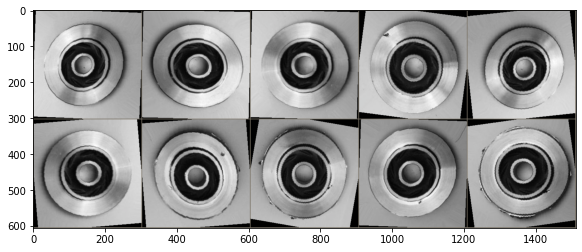

In [55]:
im = make_grid(images,nrow=5)
inv_normalise = transforms.Normalize([-0.485/0.229,-0.456/0.224,-0.406/0.225],
                         [1/0.229,1/0.224,1/0.225])

im_inv = inv_normalise(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

In [16]:
for i,(X_train,y_train) in enumerate(train):
    break

In [25]:
x = X_train.view(10,-1)

In [70]:
class Convolution(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(73*73*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
            
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,73*73*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x,dim = 1)

In [71]:
model = Convolution()
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters())

In [72]:
model

Convolution(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=85264, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [ ]:
epochs = 5

max_trn_batch = 800
max_test_batch = 300
train_loss = []
test_loss = []
train_correct = []
test_correct = []

for i in range(epochs):
    test_crr = 0
    train_crr = 0 
    print(f"{'Epoch:':<15}{i+1:>5}")
    print()
    for b,(X_train,y_train) in enumerate(tqdm(train,desc='Iteration')):
        if b == max_trn_batch:
            break
        b+=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted==y_train).sum()
        train_crr+=batch_corr
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
                 
    train_loss.append(loss)
    train_correct.append(train_crr)
    print(f"{'Loss:':<15}{loss:>5}",
        f"{'Accuracy:':<15}{(train_crr.item()*100/(10*b)):>5}")
    
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test):
            if b==max_test_batch:
                break
            y_val = model(X_test)
            predicted = torch.max(y_val.data,1)[1]
            batch_corr = (predicted==y_test).sum()
            test_crr+=batch_corr
            
    loss = criterion(y_val,y_test)
    test_loss.append(loss)
    test_correct.append(test_crr)

Epoch:             1



Iteration:   8%|██▍                              | 50/664 [00:06<01:22,  7.48it/s]


Loss:          1.3113017871546617e-07 Accuracy:      100.0
Epoch:             2



Iteration:   8%|██▍                              | 50/664 [00:06<01:21,  7.54it/s]


Loss:          1.478185140513233e-06 Accuracy:      100.0
Epoch:             3



Iteration:   1%|▏                                 | 4/664 [00:00<01:39,  6.65it/s]

In [76]:
torch.save(model.state_dict(),'castingmodel.h5')

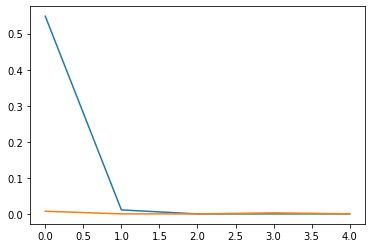

In [96]:
plt.plot([i.detach().numpy() for i in train_loss])
plt.plot([i.detach().numpy() for i in test_loss])

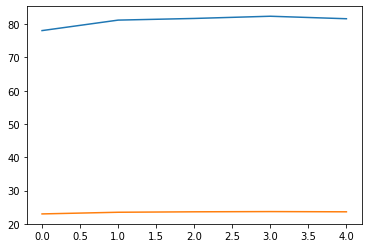

In [90]:
plt.plot([p/80 for p in train_correct],label='train')
plt.plot([p/30 for p in test_correct],label = 'valid')

In [118]:
root = '../Desktop/DRL/casting_data/casting_data/train/def_front/cast_def_0_1025.jpeg'
im = Image.open(root)
im = test_transforms(im)

im = im.reshape((1,im.shape[0],im.shape[1],im.shape[2]))
y = model(im)
print(cid[torch.max(y,1)[1].numpy()[0]])


def_front


In [127]:
test_correct[-1]/len(test_data)

tensor(0.9902)